MATH 448   
HOMEWORK CH 7  
Andrew Dahlstrom  
5/5/24

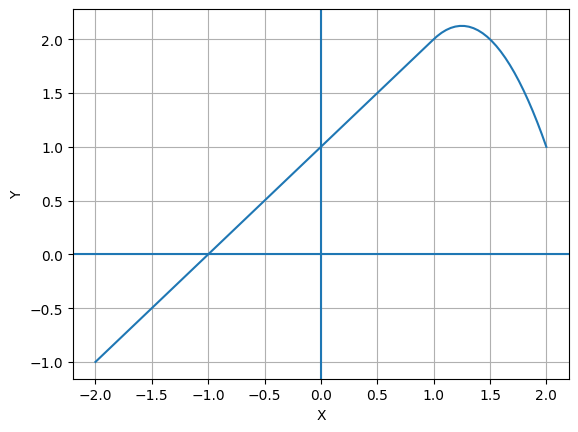

In [7]:
# 3)
import numpy as np
import matplotlib.pyplot as plt

# Define the basis and linear regressionfunctions
def b1(X):
    return X

def b2(X):
    return (X - 1) ** 2 * (X >= 1)

def linear_reg(X, B0, B1, B2):
    return B0 + B1 * b1(X) + B2 * b2(X)

# Coefficient estimates
B0 = 1
B1 = 1
B2 = -2

# X boundary
X = np.linspace(-2, 2, 100)

# Fit linear regression model
Y = linear_reg(X, B0, B1, B2)

# Plot curve
plt.plot(X, Y)
plt.xlabel('X')
plt.ylabel('Y')
plt.axhline()
plt.axvline()
plt.grid()
plt.show()

In [1]:
# From the graph above we can note the X intercept occures at Y = 1, the Y intercept occures at X = -1, the slope is 1 until X = 1.25 then is -x^2 after X = 1.25

In [10]:
# 6) a)
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from statsmodels.api import OLS, add_constant
from statsmodels.stats.anova import anova_lm

# Load the data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MATH 448/Wage.csv')

# Create the predictors dataset, and response dataset
X = data['age'].values.reshape(-1, 1)
y = data['wage']

# Initialize validation with 5 folds
cross_val = KFold(n_splits=5, shuffle=True, random_state=5)

# Create range of degrees of polynomial to try
degrees = np.arange(1, 10)

# Initialize list to store MSEs for different polynomials
mean_scores = []

# For each degree of polynomial to try
for d in degrees:
    # Create a pipeline transforms data to a polynomial degree d
    # and applies linear regression
    model = make_pipeline(PolynomialFeatures(degree=d), LinearRegression())
    # Perform cross-validation to evaluate model's performance using negative
    # mean squared error then negate it to get positive value where lower is better
    score = -cross_val_score(model, X, y, cv=cross_val, scoring='neg_mean_squared_error').mean()
    mean_scores.append(score)

# Determine the best degree
best_degree = degrees[np.argmin(mean_scores)]

In [11]:
# Fit model with the best degree
best_model = make_pipeline(PolynomialFeatures(degree=best_degree), LinearRegression())
best_model.fit(X, y)

# Create a list of models, each fitted with polynomial features up to the 'best_degree' found earlier
models = [best_model.fit(X, y) for d in degrees if d <= best_degree]

# Initialize a list to hold the results of ANOVA analysis
anova_results = []

# Loop over each degree and corresponding model
for d, model in zip(degrees[1:best_degree+1], models[1:]):
    # Transform the age data to polynomial of degree d
    polynomial_features = PolynomialFeatures(degree=d).fit_transform(X)
    # Add a constant term to polynomial for intercept
    polynomial_features_with_constant = add_constant(polynomial_features)
    # Predict wage using model trained for degree d
    predictions = model.predict(X)
    # Fit an OLS regression model using predictions as response and polynomial predictors
    ols_model = OLS(predictions, polynomial_features_with_constant).fit()
    # Append fitted OLS model to list to use in ANOVA
    anova_results.append(ols_model)

# Perform ANOVA to compare models stored in anova_results using Type 1 sums of squares
anova_table = anova_lm(*anova_results, typ=1)

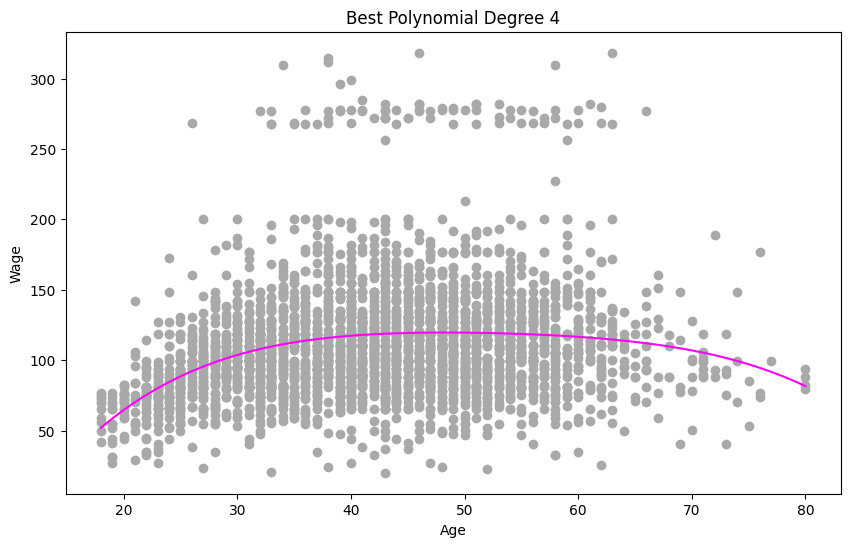

The best degree of polynomial from cross validations is: 4.
ANOVA results:
   df_resid           ssr  df_diff       ss_diff             F  Pr(>F)
0    2997.0  2.182585e+04      0.0           NaN           NaN     NaN
1    2996.0  6.070152e+03      1.0  15755.693639  2.866604e+19     0.0
2    2995.0  1.646139e-12      1.0   6070.152124  1.104409e+19     0.0


In [23]:
# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='darkgray')
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
plt.plot(x_range, best_model.predict(x_range), color='magenta')
plt.xlabel('Age')
plt.ylabel('Wage')
plt.title(f'Best Polynomial Degree {best_degree}')
plt.show()

# Output the results
print(f"The best degree of polynomial from cross validations is: {best_degree}.")
print("ANOVA results:")
print(anova_table)

In [19]:
# 6) b)

# Define function to create bins
def create_bins(X, n_bins):
    bins = np.linspace(X.min(), X.max(), n_bins + 1)
    # Assign each value in X to a bin index
    bin_indices = np.digitize(X, bins=bins, right=True)
    # np.digitize assigns indices starting from 1 so subtract 1 to make them start from 0
    adjusted_indices = bin_indices - 1
    # Ensure the output is one-dimensional
    return adjusted_indices.flatten()

bin_range = range(2, 20)
avg_scores = []

# Cross validate with different numbers of bins
for n_bins in bin_range:
    # Transform predictors into bins
    X_binned = create_bins(X, n_bins)
    model = LinearRegression()

    # Convert binned data into one hot encoding for regression
    X_binned_encoded = pd.get_dummies(X_binned).values

    # Perform cross-validation to evaluate model's performance using negative
    # mean squared error then negate it to get positive value where lower is better
    score = -cross_val_score(model, X_binned_encoded, y, cv=cross_val, scoring='neg_mean_squared_error').mean()
    avg_scores.append(score)

# Select the optimal number of bins
optimal_bins = bin_range[np.argmin(avg_scores)]

In [21]:
# Fit model with optimal number of bins
X_binned_optimal = create_bins(X, optimal_bins)
X_binned_optimal_encoded = pd.get_dummies(X_binned_optimal).values
# Fit linear regression model using optimal number of bins
X_binned_optimal_model = LinearRegression().fit(X_binned_optimal_encoded, y)

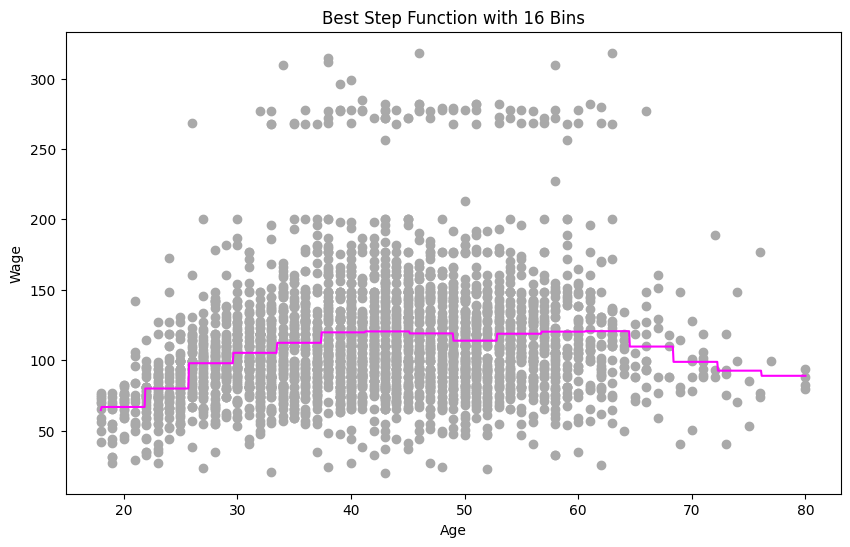

In [25]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='darkgray')
x_range = np.linspace(X.min(), X.max(), 1000)
x_binned_range = create_bins(x_range.reshape(-1, 1), optimal_bins)
x_binned_range_encoded = pd.get_dummies(x_binned_range).values
plt.plot(x_range, X_binned_optimal_model.predict(x_binned_range_encoded), color='magenta')
plt.xlabel('Age')
plt.ylabel('Wage')
plt.title(f'Best Step Function with {optimal_bins} Bins')
plt.show()

In [28]:
# 9)
# Load Boston dataset
boston = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MATH 448/Boston.csv')
dis = boston['dis']
nox = boston['nox']

                            OLS Regression Results                            
Dep. Variable:                    nox   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     419.3
Date:                Mon, 06 May 2024   Prob (F-statistic):          2.71e-136
Time:                        05:12:15   Log-Likelihood:                 690.44
No. Observations:                 506   AIC:                            -1373.
Df Residuals:                     502   BIC:                            -1356.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9341      0.021     45.110      0.0

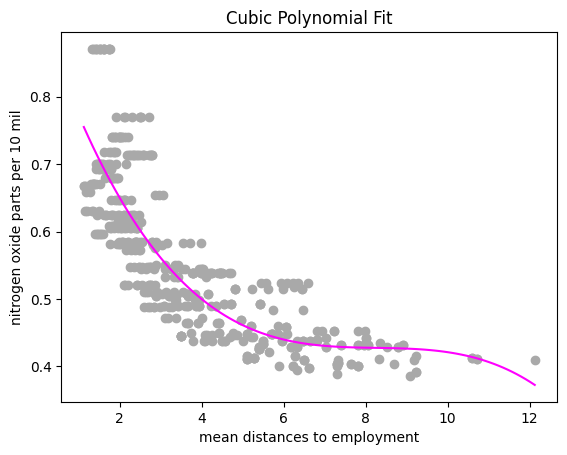

In [31]:
import statsmodels.api as sm
# a)
# Fit cubic polynomial regression
poly = PolynomialFeatures(degree=3)
X_cubic = poly.fit_transform(dis.values.reshape(-1, 1))
model_cubic = sm.OLS(nox, X_cubic).fit()
print(model_cubic.summary())

# Plotting the data and the polynomial fit
plt.scatter(dis, nox, color='darkgray')
dis_range = np.linspace(dis.min(), dis.max(), 100).reshape(-1, 1)
plt.plot(dis_range, model_cubic.predict(poly.transform(dis_range)), color='magenta')
plt.xlabel('mean distances to employment')
plt.ylabel('nitrogen oxide parts per 10 mil')
plt.title('Cubic Polynomial Fit')
plt.show()

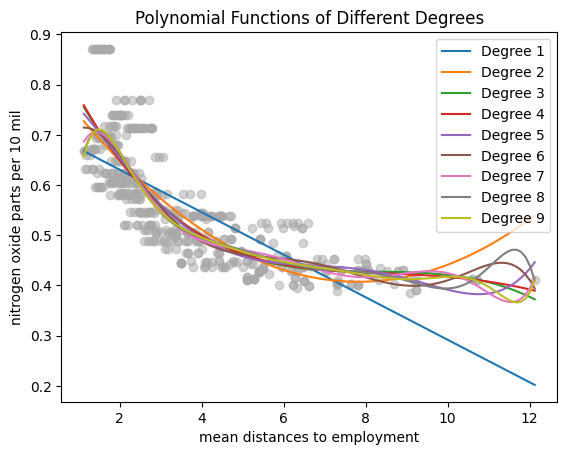

Degree 1: RSS = 2.7685628589692763
Degree 2: RSS = 2.0352618689352564
Degree 3: RSS = 1.9341067071790705
Degree 4: RSS = 1.9329813272985938
Degree 5: RSS = 1.9152899610843046
Degree 6: RSS = 1.8782572985081654
Degree 7: RSS = 1.8494836145829856
Degree 8: RSS = 1.835629689067833
Degree 9: RSS = 1.8333308045098116


In [35]:
# b)
# Initialize an empty list to store Residual Sum of Squares (RSS) for each polynomial degree function
rss_resuts = []

# Define a range of polynomial degrees to evaluate
degrees = np.arange(1, 10)

# Loop over each degree to fit a polynomial regression model
for degree in degrees:
    # Create polynomial features for the current degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the dis data to include polynomial terms up to the current degree
    X_poly = poly.fit_transform(dis.values.reshape(-1, 1))

    # Fit an Ordinary Least Squares regression using the polynomial transformed predictors
    poly_model = sm.OLS(nox, X_poly).fit()

    # Calculate the RSS for the current model and append to the list
    rss_resuts.append(np.sum((nox - poly_model.predict(X_poly)) ** 2))

    # Generate points for plotting the polynomial curve
    dis_range = np.linspace(dis.min(), dis.max(), 100).reshape(-1, 1)

    # Transform dis_range using the polynomial features transformation for the current degree
    transformed_dis_range = poly.transform(dis_range)

    # Use the fitted model to predict nox values for the transformed dis_range
    predicted_nox_values = poly_model.predict(transformed_dis_range)

    # Plot the polynomial curve for the current degree
    plt.plot(dis_range, predicted_nox_values, label=f'Degree {degree}')

# Plot the original data points
plt.scatter(dis, nox, color='darkgray', alpha=0.5)

# Set labels and title for the plot
plt.xlabel('mean distances to employment')
plt.ylabel('nitrogen oxide parts per 10 mil')
plt.title('Polynomial Functions of Different Degrees')

# Add a legend to the plot to indicate different polynomial degrees
plt.legend()

# Display the plot
plt.show()

# Loop through each degree and its corresponding RSS value
for degree, rss in zip(degrees, rss_resuts):
    # Print the degree and its corresponding RSS
    print(f"Degree {degree}: RSS = {rss}")

In [50]:
# c)
Best_degree = None
min_score = np.inf

# Loop over range of polynomial degrees to find the best one using cross-validation
for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(dis.values.reshape(-1, 1))
    model = LinearRegression()
    # Compute the mean squared error using cross validation
    mse = -np.mean(cross_val_score(model, X_poly, nox, scoring='neg_mean_squared_error', cv=cross_val))
    # Calculate RSS by multiplying MSE by the number of samples
    rss = mse * len(nox)
    # If the current RSS is lower than the previously recorded, update best degree and min_score
    if rss < min_score:
        min_score = rss
        Best_degree = degree

print(f"Best degree polynomial by cross validation is degree {Best_degree} with an RSS {min_score}")

Best degree polynomial by cross validation is degree 4 with an RSS 1.947713085606232


Based on the cross validation results a fourth degree polynomial provides the best fit to the data among the tested degrees of 1 - 9.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    nox   No. Observations:                  506
Model:                            GLM   Df Residuals:                      501
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                       0.0038379
Method:                          IRLS   Log-Likelihood:                 691.93
Date:                Mon, 06 May 2024   Deviance:                       1.9228
Time:                        05:46:05   Pearson chi2:                     1.92
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9181
Covariance Type:            nonrobust                                         
                                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

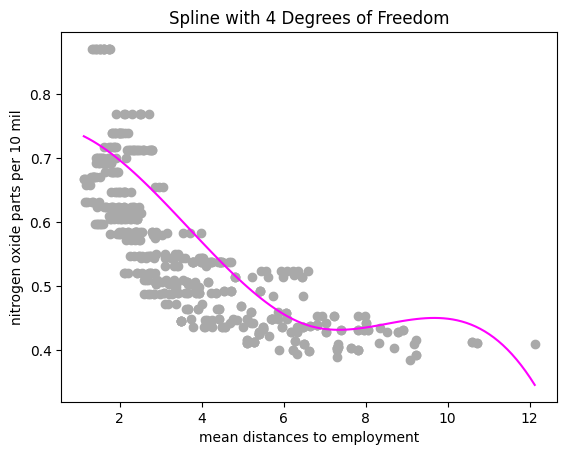

In [42]:
# d)
# The bs function from ISLP.models module does not exist in Python,
# using similar patsy from statsmodels
from patsy import dmatrix

# Fit spline with 4 degrees of freedom
transformed_x = dmatrix("bs(dis, df=4, include_intercept=False)", {"dis": dis}, return_type='dataframe')
fit = sm.GLM(nox, transformed_x).fit()
print(fit.summary())

# Plot the spline fit
plt.scatter(dis, nox, color='darkgray')
line_x = np.linspace(dis.min(), dis.max(), 100)
line_x_transformed = dmatrix("bs(line_x, df=4, include_intercept=False)", {"line_x": line_x}, return_type='dataframe')

plt.plot(line_x, fit.predict(line_x_transformed), color='magenta')
plt.xlabel('mean distances to employment')
plt.ylabel('nitrogen oxide parts per 10 mil')
plt.title('Spline with 4 Degrees of Freedom')
plt.show()

Generally speaking the number of knots is equal to degrees of freedom minus the degree of the spline minus one. In this question with four degrees of freedom the default setting was used and the knots are automatically placed at strategic quantiles of the distance dataset.

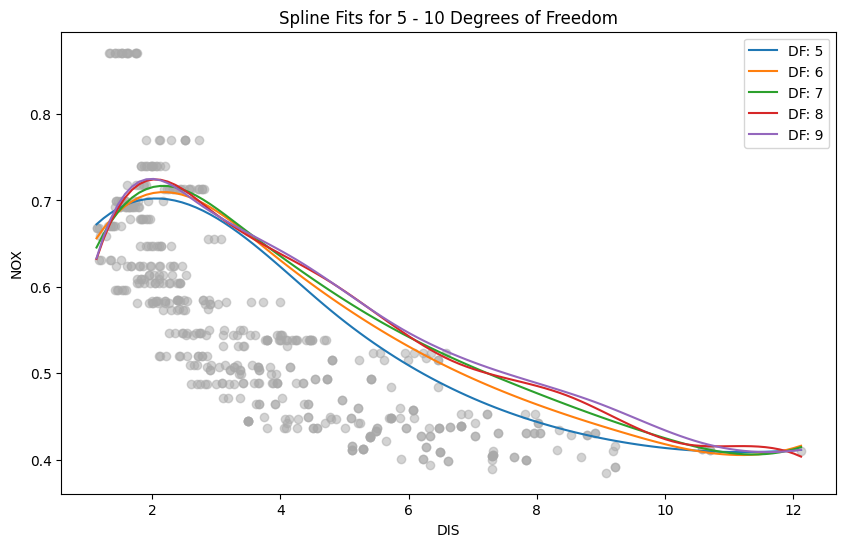

Degree of freedom 5: RSS = 1.8401728014885235
Degree of freedom 6: RSS = 1.8339659031602096
Degree of freedom 7: RSS = 1.8298844459232841
Degree of freedom 8: RSS = 1.8169950567252333
Degree of freedom 9: RSS = 1.825652510387056


In [48]:
# e)
# Define a range of degrees of freedom to test
df_range = np.arange(5, 10)
rss = []

# Plotting setup
fig, ax = plt.subplots(figsize=(10, 6))

# Loop over each degree of freedom in range
for df in df_range:
    # Fit spline with df degrees of freedom
    transformed_x = dmatrix(f"bs(dis, df={df}, include_intercept=False)", {"dis": dis}, return_type='dataframe')
    model = sm.GLM(nox, transformed_x).fit()
    rss.append(np.sum((nox - model.predict())**2))

    # Plot the spline fit
    line_x = np.linspace(dis.min(), dis.max(), 100)
    line_x_transformed = dmatrix(f"bs(line_x, df={df}, include_intercept=False)", {"line_x": line_x}, return_type='dataframe')
    ax.plot(line_x, model.predict(line_x_transformed), label=f'DF: {df}')

# Finish plot setup
ax.scatter(dis, nox, color='darkgray', alpha=0.5)
ax.set_xlabel('DIS')
ax.set_ylabel('NOX')
ax.set_title('Spline Fits for 5 - 10 Degrees of Freedom')
ax.legend()
plt.show()

# Loop through each degree and its corresponding RSS value
for df, rss in zip(df_range, rss):
    # Print the degree and its corresponding RSS
    print(f"Degree of freedom {df}: RSS = {rss}")

We can see that as the degree of freedom increases up until 8 the RSS decreases however at degree of freedom 9 it increases slightly.

In [52]:
# f)
best_df = None
min_rss = np.inf
df_range = np.arange(4, 10)

# Loop over degrees of freedom and use cross-validation to select the best degree
for df in df_range:
    rss_list = []
    for train_index, test_index in cross_val.split(dis):
        x_train, x_test = dis.iloc[train_index], dis.iloc[test_index]
        y_train, y_test = nox.iloc[train_index], nox.iloc[test_index]

        # Spline transformation for training and testing
        x_train_transformed = dmatrix(f"bs(x_train, df={df}, include_intercept=False)", {"x_train": x_train}, return_type='dataframe')
        x_test_transformed = dmatrix(f"bs(x_test, df={df}, include_intercept=False)", {"x_test": x_test}, return_type='dataframe')

        model = sm.GLM(y_train, x_train_transformed).fit()
        predictions = model.predict(x_test_transformed)
        # Calculate RSS for the current fold and add it to the list
        rss = np.sum((y_test - predictions) ** 2)
        rss_list.append(rss)

    # Calculate the average RSS over all folds
    avg_rss = np.mean(rss_list)
    # If the current average RSS is lower than the previously minimum, update best_df and min_rss
    if avg_rss < min_rss:
        min_rss = avg_rss
        best_df = df

print(f"Best degree of freedom using cross validation: {best_df} with RSS {min_rss}")

Best degree of freedom using cross validation: 5 with RSS 0.4052162549113003


Based on the cross validation results four degrees of freedom provides the best fit to the data among the tested degrees of 4 - 10 with an RSS of approximately .4